In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
xwolf12_datasetandroidpermissions_path = kagglehub.dataset_download('xwolf12/datasetandroidpermissions')
xwolf12_network_traffic_android_malware_path = kagglehub.dataset_download('xwolf12/network-traffic-android-malware')

print('Data source import complete.')


100%|██████████| 9.03k/9.03k [00:00<00:00, 13.3MB/s]

Extracting files...


100%|██████████| 114k/114k [00:00<00:00, 46.4MB/s]

Extracting files...
Data source import complete.


# Android Malware Analysis

### Packages

In [3]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn import preprocessing
import torch
from sklearn import svm
from sklearn import tree
import pandas as pd
!pip install joblib #NEW
import joblib #NEW
import pickle
import numpy as np
import seaborn as sns

### Exploratory

In [4]:
import pandas as pd
df = pd.read_csv("train.csv", sep=";") # before: df = pd.read_csv("../input/datasetandroidpermissions/train.csv", sep=";")

In [19]:
#df
dfFlip = df.copy()
for i in dfFlip.index:
    if i%3 == 0:
      dfFlip.at[i, 'type'] = 1 if (dfFlip.at[i, 'type'] == 0) else 0
dfFlip

,android,android.app.cts.permission.TEST_GRANTED,android.intent.category.MASTER_CLEAR.permission.C2D_MESSAGE,android.os.cts.permission.TEST_GRANTED,android.permission.ACCESS_ALL_DOWNLOADS,android.permission.ACCESS_ALL_EXTERNAL_STORAGE,android.permission.ACCESS_BLUETOOTH_SHARE,android.permission.ACCESS_CACHE_FILESYSTEM,android.permission.ACCESS_CHECKIN_PROPERTIES,android.permission.ACCESS_COARSE_LOCATION,...,com.android.voicemail.permission.WRITE_VOICEMAIL,com.foo.mypermission,com.foo.mypermission2,org.chromium.chrome.shell.permission.C2D_MESSAGE,org.chromium.chrome.shell.permission.DEBUG,org.chromium.chrome.shell.permission.SANDBOX,org.chromium.chromecast.shell.permission.SANDBOX,org.chromium.content_shell.permission.SANDBOX,test_permission,type
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
394,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [20]:
dfFlip = dfFlip.astype("int64")
dfFlip.columns

Index(['android', 'android.app.cts.permission.TEST_GRANTED',
       'android.intent.category.MASTER_CLEAR.permission.C2D_MESSAGE',
       'android.os.cts.permission.TEST_GRANTED',
       'android.permission.ACCESS_ALL_DOWNLOADS',
       'android.permission.ACCESS_ALL_EXTERNAL_STORAGE',
       'android.permission.ACCESS_BLUETOOTH_SHARE',
       'android.permission.ACCESS_CACHE_FILESYSTEM',
       'android.permission.ACCESS_CHECKIN_PROPERTIES',
       'android.permission.ACCESS_COARSE_LOCATION',
       ...
       'com.android.voicemail.permission.WRITE_VOICEMAIL',
       'com.foo.mypermission', 'com.foo.mypermission2',
       'org.chromium.chrome.shell.permission.C2D_MESSAGE',
       'org.chromium.chrome.shell.permission.DEBUG',
       'org.chromium.chrome.shell.permission.SANDBOX',
       'org.chromium.chromecast.shell.permission.SANDBOX',
       'org.chromium.content_shell.permission.SANDBOX', 'test_permission',
       'type'],
      dtype='object', length=331)

In [21]:
dfFlip['type']

,type
0,0
1,1
2,1
3,0
4,1
...,...
393,1
394,0
395,0
396,1


Type is the label that represents if an application is a malware or not, as we can see this dataset is balanced.

In [22]:
dfFlip.type.value_counts()

,count
type,
0,200
1,198


In [23]:
dfFlip.shape

(398, 331)

*Let's get the top 10 of permissions that are used for our malware samples*

*Malicious*

In [24]:
pd.Series.sort_values(dfFlip[dfFlip.type==1].sum(axis=0), ascending=False)[1:11]

,0
android.permission.INTERNET,166
android.permission.READ_PHONE_STATE,135
android.permission.ACCESS_NETWORK_STATE,127
android.permission.WRITE_EXTERNAL_STORAGE,116
android.permission.ACCESS_WIFI_STATE,104
android.permission.READ_SMS,81
android.permission.RECEIVE_BOOT_COMPLETED,77
android.permission.WRITE_SMS,68
android.permission.WAKE_LOCK,61
android.permission.ACCESS_COARSE_LOCATION,59


*Benign*

In [25]:
pd.Series.sort_values(dfFlip[dfFlip.type==0].sum(axis=0), ascending=False)[:10]

,0
android.permission.INTERNET,133
android.permission.ACCESS_NETWORK_STATE,102
android.permission.WRITE_EXTERNAL_STORAGE,96
android.permission.READ_PHONE_STATE,79
android.permission.ACCESS_WIFI_STATE,60
android.permission.RECEIVE_BOOT_COMPLETED,55
android.permission.READ_SMS,47
android.permission.WAKE_LOCK,40
android.permission.WRITE_SMS,37
android.permission.VIBRATE,35


<Axes: >

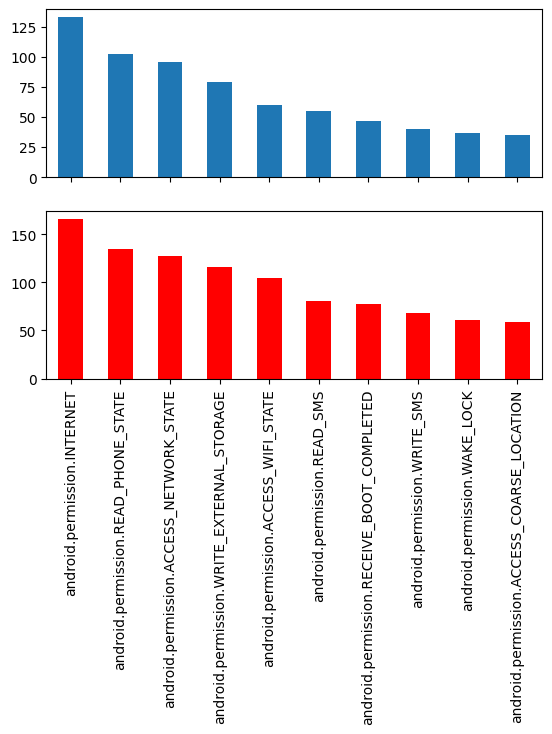

In [26]:
import matplotlib.pyplot as plt
fig, axs =  plt.subplots(nrows=2, sharex=True)

pd.Series.sort_values(dfFlip[dfFlip.type==0].sum(axis=0), ascending=False)[:10].plot.bar(ax=axs[0])
pd.Series.sort_values(dfFlip[dfFlip.type==1].sum(axis=0), ascending=False)[1:11].plot.bar(ax=axs[1], color="red")

The last outputs allow us to get insights about a difference between the permissions used by the malware and the benign applications.

### Modeling

In [27]:
X_train, X_test, y_train, y_test = train_test_split(dfFlip.iloc[:, 1:330], dfFlip['type'], test_size=0.20, random_state=42)

*Naive Bayes algorithm*

In [28]:
# Naive Bayes algorithm
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# pred
pred = gnb.predict(X_test)

# accuracy
accuracy = accuracy_score(pred, y_test)
print("naive_bayes")
print(accuracy)
print(classification_report(pred, y_test, labels=None))

naive_bayes
0.475
              precision    recall  f1-score   support

           0       0.07      0.43      0.12         7
           1       0.90      0.48      0.62        73

    accuracy                           0.47        80
   macro avg       0.49      0.45      0.38        80
weighted avg       0.83      0.47      0.58        80



*kneighbors algorithm*

In [16]:
# kneighbors algorithm

for i in range(3,15,3):

    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train)
    pred = neigh.predict(X_test)
    # accuracy
    accuracy = accuracy_score(pred, y_test)
    print("kneighbors {}".format(i))
    print(accuracy)
    print(classification_report(pred, y_test, labels=None))
    print("")

kneighbors 3
0.8875
              precision    recall  f1-score   support

           0       0.85      0.95      0.90        41
           1       0.94      0.82      0.88        39

    accuracy                           0.89        80
   macro avg       0.89      0.89      0.89        80
weighted avg       0.89      0.89      0.89        80


kneighbors 6
0.875
              precision    recall  f1-score   support

           0       0.83      0.95      0.88        40
           1       0.94      0.80      0.86        40

    accuracy                           0.88        80
   macro avg       0.88      0.88      0.87        80
weighted avg       0.88      0.88      0.87        80


kneighbors 9
0.8625
              precision    recall  f1-score   support

           0       0.80      0.95      0.87        39
           1       0.94      0.78      0.85        41

    accuracy                           0.86        80
   macro avg       0.87      0.86      0.86        80
weighted avg 

*Decision Tree*

In [17]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Read the csv test file

pred = clf.predict(X_test)
# accuracy
accuracy = accuracy_score(pred, y_test)
print(clf)
print(accuracy)
print(classification_report(pred, y_test, labels=None))

DecisionTreeClassifier()
0.95
              precision    recall  f1-score   support

           0       0.93      0.98      0.96        44
           1       0.97      0.92      0.94        36

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



Through the last results we can see how we trained different classifiers to detect malware using its permissions, but as I said this is only a first approximation, I didn't analyze the hyperparameters and others things to improve the results.

# Dynamic Analysis

In [18]:
import pandas as pd
data = pd.read_csv("../input/network-traffic-android-malware/android_traffic.csv", sep=";")
data.head()

FileNotFoundError: [Errno 2] No such file or directory: '../input/network-traffic-android-malware/android_traffic.csv'

In [ ]:
data.columns

In [ ]:
data.shape

In [ ]:
data.type.value_counts()

In this case, we have an unbalanced dataset, so another model evaluation will be used.

### Data Cleaning and Processing

In [ ]:
data.isna().sum()

In [ ]:
data = data.drop(['duracion','avg_local_pkt_rate','avg_remote_pkt_rate'], axis=1).copy()

In [ ]:
data.describe()

Now, the idea is to see the outliers in the data

In [ ]:
sns.boxplot(data.tcp_urg_packet)

In [ ]:
data.loc[data.tcp_urg_packet > 0].shape[0]

That column will be no used for the analysis, only two rows are different to zero, maybe they are interesting for future analysis.

In [ ]:
data = data.drop(columns=["tcp_urg_packet"], axis=1).copy()
data.shape

In [ ]:
sns.pairplot(data)

We have many outliers in some features, I will omit the depth analysis and only get the set of the data without the noise.

In [ ]:
data=data[data.tcp_packets<20000].copy()
data=data[data.dist_port_tcp<1400].copy()
data=data[data.external_ips<35].copy()
data=data[data.vulume_bytes<2000000].copy()
data=data[data.udp_packets<40].copy()
data=data[data.remote_app_packets<15000].copy()

In [ ]:
data[data.duplicated()].sum()

In [ ]:
data=data.drop('source_app_packets.1',axis=1).copy()

In [ ]:
scaler = preprocessing.RobustScaler()
scaledData = scaler.fit_transform(data.iloc[:,1:11])
scaledData = pd.DataFrame(scaledData, columns=['tcp_packets','dist_port_tcp','external_ips','vulume_bytes','udp_packets','source_app_packets','remote_app_packets',' source_app_bytes','remote_app_bytes','dns_query_times'])

From [6] we concluded that the best network features are:

+ (R1): TCP packets, it has the number of packets TCP sent and got during communication.
+ (R2): Different TCP packets, it is the total number of packets different from TCP.
+ (R3): External IP, represents the number the external addresses (IPs) where the application tried to communicated
+ (R4): Volume of bytes, it is the number of bytes that was sent from the application to the external sites
+ (R5) UDP packets, the total number of packets UDP transmitted in a communication.
+ (R6) Packets of the source application, it is the number of packets that were sent from the application to a remote server.
+ (R7) Remote application packages, number of packages received from external sources.
+ (R8) Bytes of the application source, this is the volume (in Bytes) of the communication between the application and server.
+ (R9) Bytes of the application remote, this is the volume (in Bytes) of the data from the server to the emulator.
+ (R10) DNS queries, number of DNS queries.


### Modeling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaledData.iloc[:,0:10], data.type.astype("str"), test_size=0.25, random_state=45)

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
pred = gnb.predict(X_test)
## accuracy
accuracy = accuracy_score(y_test,pred)
print("naive_bayes")
print(accuracy)
print(classification_report(y_test,pred, labels=None))
print("cohen kappa score")
print(cohen_kappa_score(y_test, pred))

In [ ]:
# kneighbors algorithm

for i in range(3,15,3):

    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train)
    pred = neigh.predict(X_test)
    # accuracy
    accuracy = accuracy_score(pred, y_test)
    print("kneighbors {}".format(i))
    print(accuracy)
    print(classification_report(pred, y_test, labels=None))
    print("cohen kappa score")
    print(cohen_kappa_score(y_test, pred))
    print("")

In [ ]:
rdF=RandomForestClassifier(n_estimators=250, max_depth=50,random_state=45)
rdF.fit(X_train,y_train)
pred=rdF.predict(X_test)
cm=confusion_matrix(y_test, pred)

accuracy = accuracy_score(y_test,pred)
print(rdF)
print(accuracy)
print(classification_report(y_test,pred, labels=None))
print("cohen kappa score")
print(cohen_kappa_score(y_test, pred))
print(cm)